In [1]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random
import string
%matplotlib inline

In [2]:
MULTITHREADING_TITLE="Multithreading"

def visualize_runtimes(results, title):
    start,stop = np.array(results).T
    plt.barh(range(len(start)),stop-start,left=start)
    plt.grid(axis='x')
    plt.ylabel("Tasks")
    plt.xlabel("Seconds")
    plt.title(title)
    return stop[-1]-start[0]

In [3]:
# Recommended example from Python documentation:
# https://docs.python.org/3/library/concurrent.futures.html
import concurrent.futures
import urllib.request

URLS = ['http://www.foxnews.com/',
        'http://www.cnn.com/',
        'http://europe.wsj.com/',
        'http://www.bbc.co.uk/',
        'http://some-made-up-domain.com/']

# Retrieve a single page and report the URL and contents
def load_url(url, timeout):
    with urllib.request.urlopen(url, timeout=timeout) as conn:
        return conn.read()

# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = {executor.submit(load_url, url, 60): url for url in URLS}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            data = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))
        else:
            print('%r page is %d bytes' % (url, len(data)))

'http://www.foxnews.com/' page is 293350 bytes
'http://www.cnn.com/' page is 1114956 bytes
'http://europe.wsj.com/' generated an exception: HTTP Error 403: Forbidden
'http://some-made-up-domain.com/' generated an exception: HTTP Error 400: Bad Request
'http://www.bbc.co.uk/' page is 365616 bytes


In [4]:
# Recommended usage
# https://docs.python.org/3/library/concurrent.futures.html
def multithreading_official_example(func, args, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        future = executor.submit(func, args, [begin_time for i in range(len(args))]) 
    return future.result

# Dirty example that works for demonstration only.
# This is not the recommended practice.
# https://medium.com/@bfortuner/python-multithreading-vs-multiprocessing-73072ce5600b
def multithreading(func, args, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)
        

# API Calls

In [5]:
from urllib.request import urlopen

def download(url, base):
    start = time.time() - base
    try:
        resp = urlopen(url)
    except Exception as e:
        print ('ERROR: %s' % e)
    stop = time.time() - base
    return start,stop

In [6]:
N = 16
URL = 'http://scholar.princeton.edu/sites/default/files/oversize_pdf_test_0.pdf'
urls = [URL for i in range(N)]

#### Serial

In [7]:
%timeit -n 1 [download(url, 1) for url in urls]

10.2 s ± 276 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

9.979002237319946

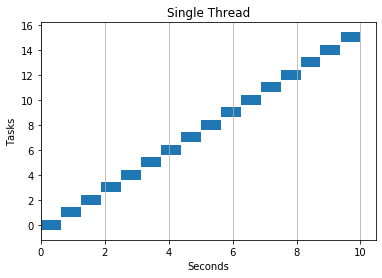

In [8]:
visualize_runtimes(multithreading(download, urls, 1), "Single Thread")

5.085002422332764

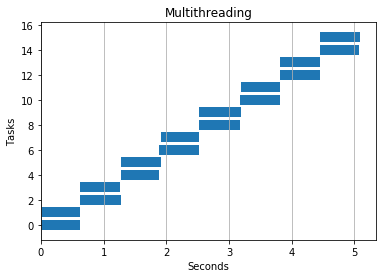

In [9]:
visualize_runtimes(multithreading(download, urls, 2),MULTITHREADING_TITLE)

2.610619306564331

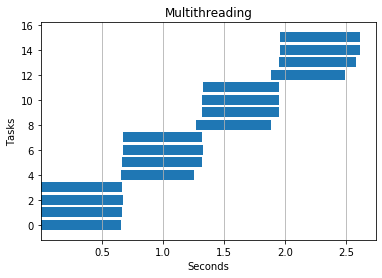

In [10]:
visualize_runtimes(multithreading(download, urls, 4),MULTITHREADING_TITLE)

# IO Heavy

In [11]:
def io_heavy(text,base):
    start = time.time() - base
    f = open('output.txt', 'wt', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - base
    return start,stop

In [12]:
N=4
TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**7*5))

#### Serial

In [13]:
%timeit -n 1 [io_heavy(TEXT,1) for i in range(N)]

394 ms ± 67.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

Should see good benefit from this

0.38628196716308594

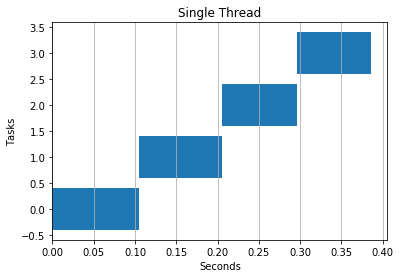

In [14]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 1),"Single Thread")

0.3185923099517822

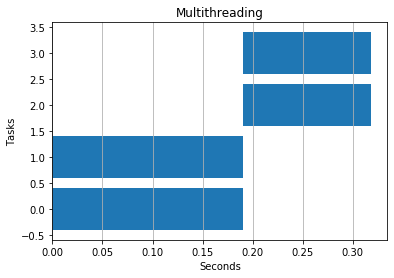

In [15]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 2),MULTITHREADING_TITLE)

0.16012883186340332

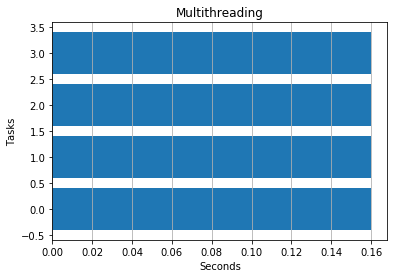

In [16]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 4),MULTITHREADING_TITLE)

# Numpy Functions

### Numpy Addition

In [17]:
#Does not use parallel processing by default
#But will see speedups if multiprocessing used
#Because numpy sidesteps python's GIL
def addition(i, base):
    start = time.time() - base
    res = a + b
    stop = time.time() - base
    return start,stop

In [18]:
DIMS = 10000
N = 10
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

#### Serial

In [19]:
%timeit -n 1 [addition(i, time.time()) for i in range(N)]

1.88 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

Some benefit for numpy addition (operation avoids GIL, but not parallel by default)

1.6659870147705078

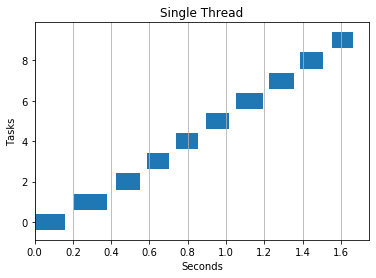

In [20]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 1),"Single Thread")

1.6644287109375

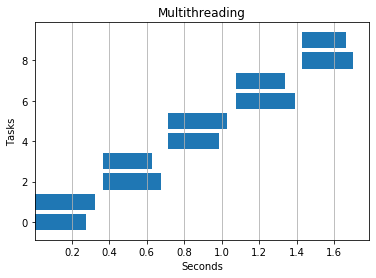

In [21]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 2),MULTITHREADING_TITLE)

1.6928296089172363

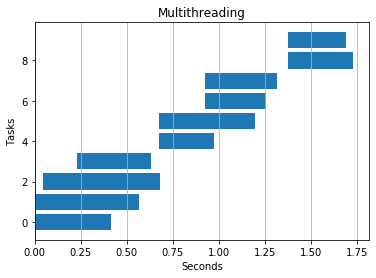

In [22]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 4),MULTITHREADING_TITLE)

### Dot Product

In [23]:
#Automatic parallel processing built works out of the box
#Depending on BLAS impl, MKL (default with anaconda3) does
#Should NOT see speedups with multithreading/processing
def dot_product(i, base):
    start = time.time() - base
    res = np.dot(a,b)
    stop = time.time() - base
    return start,stop

DIMS = 3000
N = 12
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

#### Serial

In [24]:
%timeit -n 1 [dot_product(i, time.time()) for i in range(N)]

3.82 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

No benefit on dot product (since already parallel)

4.061588525772095

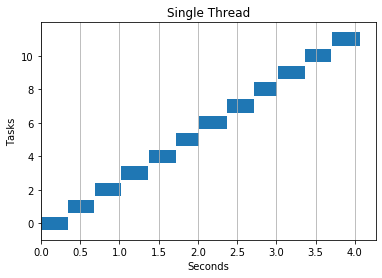

In [25]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 1),"Single Thread")

3.2553303241729736

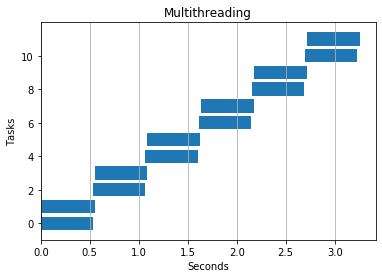

In [26]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 2),MULTITHREADING_TITLE)

### CPU Intensive

In [27]:
def cpu_heavy(n,base):
    start = time.time() - base
    count = 0
    for i in range(n):
        count += i
    stop = time.time() - base
    return start,stop

In [28]:
N = 10**5
ITERS = 10

#### Serial

In [29]:
%timeit -n 1 [cpu_heavy(N, time.time()) for i in range(ITERS)]

51.2 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

No benefit on CPU-intensive tasks

0.04999661445617676

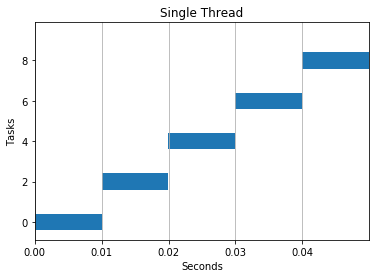

In [30]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 1),"Single Thread")

0.04998278617858887

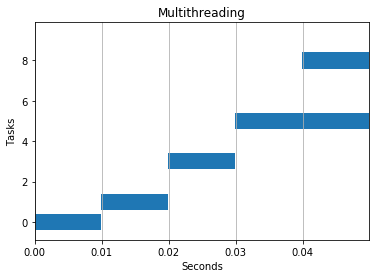

In [31]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 2),MULTITHREADING_TITLE)

0.03258323669433594

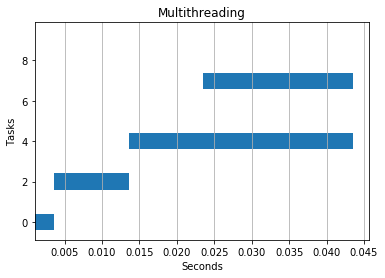

In [32]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 4),MULTITHREADING_TITLE)

# Resize Images

* https://github.com/python-pillow/Pillow/blob/c9f54c98a5dc18685a9bf8c8822f770492a796d6/_imagingtk.c

In [33]:
#This one takes IO so multithreading might be better?
def resize_img(fpath, base):
    img = Image.open(fpath)
    rimg = img.resize((224,224))
    img.close()
    return rimg

In [34]:
DATA_PATH='/home/bfortuner/workplace/data/imagenet_sample/'
fnames = list(glob.iglob(DATA_PATH+'*/*.JPEG'))
N = 1000

#### Serial

In [35]:
%timeit -n 1 [resize_img(f,1) for f in fnames[:N]]

The slowest run took 4.00 times longer than the fastest. This could mean that an intermediate result is being cached.
914 ns ± 622 ns per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

In [36]:
%timeit -n 1 multithreading(resize_img, fnames[:N], 2)

The slowest run took 4.21 times longer than the fastest. This could mean that an intermediate result is being cached.
14.8 µs ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit -n 1 multithreading(resize_img, fnames[:N], 4)

The slowest run took 4.23 times longer than the fastest. This could mean that an intermediate result is being cached.
11.2 µs ± 6.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit -n 1 multithreading(resize_img, fnames[:N], 8)

The slowest run took 4.31 times longer than the fastest. This could mean that an intermediate result is being cached.
10.2 µs ± 7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
